# Introduction

This notebook analyzes U.S. justice statistics—incident-level microdata from the Bureau of Justice Statistics’ National Crime Victimization Survey (NCVS)—to describe patterns in the offender and crime context (what happened, where/when, weapons, relationship, reporting, aftermath). 

**Unit of analysis.** Each row represents a single incident, restricted to **single-offender** cases. Records are keyed by a stable `UniqueID` built from `YEARQ`, `IDHH`, and `IDPER` with a deterministic sequence.

**What’s in scope.** The analysis draws from themed slices of the incident file:
- Offender characteristics (single-offender items)
- Incident details (time/place/context)
- Offense type
- Offender–victim relationship
- Incident reporting
- Victim self-protection
- Third-party assistance
- Victim aftermath (injury, care, costs, safety perceptions)

**What’s out of scope.** Survey/replicate **weights** and **victim demographic** variables. Results are therefore **unweighted** and descriptive; many items are **universe-restricted**, so missingness is expected outside eligible incidents.

**Data objects.** We materialize a base table, `analytic_single_offender` (indexed on `UniqueID`), and expose the themes as SQL **views** for easy joining and exploration. Details on preparation and analysis steps follow in the next section.

## Analytical Approach

This analysis uses a structured workflow centered on **thematic subsets** drawn from the NCVS **incident** file and joined by a single key (`UniqueID`). The focus is on **offender** and **incident context**; *victim demographics are excluded*.

### Planned Subsets for Study
1. **Offender Demographics** — `V4236–V4245` (sex, age, race categories for single-offender incidents)  
2. **Incident Details** — `V4012–V4025` (when/where/context)
3. **Offense Type** — `V4077–V4108` (what happened / classification)
4. **Offender–Victim Relationship** — `V4512–V4523` (relationship type)
5. **Incident Reporting** — `V4399–V4422` (reported to police; reasons)
6. **Victim Self-Protection** — `V4143–V4183` (self-protective actions)
7. **Third-Party Assistance** — `V4184–V4202` (help from others)
8. **Victim Aftermath** — `V4110–V4140A` (injury, medical care, costs, safety perceptions)

> Offense-type extras: a tidy table `offense_type_long` (melted with labels) and a per-incident flag `v_offense_type_any`.

### Process
1. **Dataset Documentation** — Note scope/structure using the official codebook.
2. **Data Preparation** — Read selected columns from `Data.sav`; drop weights (codebook row ≥ 621 and any `wgt/weight`).  
   Build `UniqueID = YEARQ_IDHH_IDPER_seq` (1-indexed sequence per `(YEARQ, IDHH, IDPER)`), index it in SQLite.  
   Restrict to **single-offender** incidents: `V4234` ≠ “More than one” and `V4249 < 2` (or missing).
3. **Subset Extraction** — For each theme above, create a SQL **view** from `analytic_single_offender`.  
   Additionally, create `offense_type_long` and `v_offense_type_any`.
4. **Labeling & Recodes** — Use SPSS value labels for readable `_label` fields; collapse rare/unknown codes where helpful; respect universe (branching) when computing denominators.
5. **Analysis** — Descriptive profiles and cross-tabs across themes (e.g., weapon × reporting, relationship × injury).  
   Optional exploratory models (unweighted) with clear caveats.

**Notes:** Results are **unweighted** and reflect only incidents in scope for each item (branching implies expected missingness).

# Dataset Description

## Overview
This dataset originates from the **Bureau of Justice Statistics (BJS)**, the principal U.S. federal statistical agency charged with collecting, analyzing, and disseminating data on **crime, criminal victimization, offenders, and the criminal justice system** across all levels of government. Established in **1979**, BJS aggregates data from thousands of agencies and publishes both microdata and summary tables via the **National Archive of Criminal Justice Data (NACJD)** :contentReference[oaicite:1]{index=1}. Their data are leveraged for policy-making, research, and public transparency.

Microdata files—including full incident-level records and codebooks—are archived in **NACJD** and form the basis for aggregated summaries in BJS reports, dashboards, and tools :contentReference[oaicite:2]{index=2}.

## Unit of Observation
- **Type**: Individual incident or victim-offender record (depending on dataset structure).
- **Geographic Scope**: United States (across states and potentially local jurisdictions).
- **Time Frame**: *2021*.

## Population Covered
Includes both **reported and unreported** incidents as collected through victimization surveys or administrative sources, reflecting multiple offender and victim characteristics.

## Data Collection Method
Records may be derived from:
- **Victimization surveys**, self-reported by individuals.
- **Administrative data**, sourced from law enforcement, courts, and correctional agencies.

These microdata are compiled, standardized, and disseminated through NACJD for public and research use.


---


# Justice Data — SQL + Python Workflow 

**Objective:** Build a reproducible **SQL–Python pipeline** for structured analysis and machine learning workflows.  
This notebook demonstrates:
- Relational **SQL schema** design and query execution
- **Python integration** for wrangling, feature engineering, and visualizations
- Foundations for applying **machine learning** techniques on structured justice data


## 1. Data Ingestion and Environment Setup

Initialize the workflow environment:
- Load raw data (`.sav` or `.csv`)
- Normalize column naming conventions for relational modeling
- Create a clean, dedicated SQLite database for reproducible SQL queries
- Define **helper functions** for:
  - Executing SQL queries (`q`, `qs`, `qc`)
  - Inspecting schemas and metadata
  - Creating snapshots for version control


### Libraries
Core imports for this pipeline:
- `sqlite3`, `pandas`, `numpy` — data storage, querying, and manipulation  
- `matplotlib` — for SQL query visualization output  
- `textwrap` and utility modules — helper formatting for clean, readable SQL execution


In [1]:
import os, re, textwrap, sqlite3, time, sys, shutil
import pandas as pd
import numpy as np

# Display options
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Project paths (adjust these)
RAW_SAV_PATH = "Data.sav"    # or change to your file
RAW_CSV_PATH = "Data.csv"    # optional alternative
DB_PATH       = "justice_data_clean.db"   # fresh DB for v2


In [2]:
# Connect/create the SQLite DB
conn = sqlite3.connect(DB_PATH)

def q(sql: str, params=None) -> pd.DataFrame:
    """Query -> DataFrame (prints a compact preview)."""
    sql = textwrap.dedent(sql).strip()
    df = pd.read_sql_query(sql, conn, params=params)
    print(f"Rows: {len(df):,} | Cols: {len(df.columns)}")
    display(df.head(10))
    return df

def qs(sql: str, params=None) -> pd.DataFrame:
    """Query -> DataFrame (silent)."""
    return pd.read_sql_query(textwrap.dedent(sql).strip(), conn, params=params)

def qc(sql: str, params=None) -> None:
    """Execute DDL/DML (CREATE, DROP, INSERT, UPDATE)."""
    with conn:
        conn.execute(textwrap.dedent(sql).strip(), params or {})

def table_cols(name: str) -> list[str]:
    """Column names for a table/view without executing it."""
    df = qs(f'PRAGMA table_info("{name}")')
    return df["name"].tolist() if "name" in df.columns else []

def list_objects() -> pd.DataFrame:
    """List tables and views."""
    return qs("""
        SELECT name, type
        FROM sqlite_master
        WHERE type IN ('table','view')
        ORDER BY type, name;
    """)

def snapshot_db(snap_name="justice_data_snapshot.db"):
    """Save a snapshot copy of the DB."""
    conn.commit()
    shutil.copy(DB_PATH, snap_name)
    print(f"Snapshot saved as {snap_name}")


### Normalize Columns

Standardize column names for:
- Compatibility with SQL syntax  
- Consistent casing (`UPPERCASE`)  
- Simplified references in Python and machine learning pipelines


In [3]:
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Uppercase, underscores, strip odd chars."""
    out = df.copy()
    out.columns = (out.columns
                   .str.strip()
                   .str.replace(r"\s+", "_", regex=True)
                   .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
                   .str.upper())
    return out


### Load Raw Data

Use the selected ingestion path:
- **SPSS:** Leverages `pyreadstat` for `.sav` ingestion into pandas  
- **CSV:** Processes chunked ingestion for large datasets  
All ingested data is written to a **staging table (`stg_incidents`)** for cleaning and transformation.


In [6]:
# If you don't have this yet:
# %pip install pyreadstat

import pyreadstat

raw_df, meta = pyreadstat.read_sav("Data.sav")
print(raw_df.shape)        # sanity check
display(raw_df.head())     # peek a few rows


(8982, 1261)


,V4001,YEARQ,IDHH,IDPER,V4002,V4003,V4004,V4005,V4006,V4008,V4009,V4010,V4011,V4012,V4013,V4014,V4015,V4016,V4017,V4018,V4019,V4021B,V4022,V4023,V4023B,V4024,V4025,V4026,V4027,V4028,V4029,V4030,V4031,V4032,V4033,V4034,V4035,V4036,V4037,V4038,V4039,V4040,V4041A,V4041B,V4041C,V4042,V4043,V4044,V4045,V4046,V4047,V4048,V4049,V4050,V4051,V4052,V4053,V4054,V4055,V4056,...,VICREPWGT101,VICREPWGT102,VICREPWGT103,VICREPWGT104,VICREPWGT105,VICREPWGT106,VICREPWGT107,VICREPWGT108,VICREPWGT109,VICREPWGT110,VICREPWGT111,VICREPWGT112,VICREPWGT113,VICREPWGT114,VICREPWGT115,VICREPWGT116,VICREPWGT117,VICREPWGT118,VICREPWGT119,VICREPWGT120,VICREPWGT121,VICREPWGT122,VICREPWGT123,VICREPWGT124,VICREPWGT125,VICREPWGT126,VICREPWGT127,VICREPWGT128,VICREPWGT129,VICREPWGT130,VICREPWGT131,VICREPWGT132,VICREPWGT133,VICREPWGT134,VICREPWGT135,VICREPWGT136,VICREPWGT137,VICREPWGT138,VICREPWGT139,VICREPWGT140,VICREPWGT141,VICREPWGT142,VICREPWGT143,VICREPWGT144,VICREPWGT145,VICREPWGT146,VICREPWGT147,VICREPWGT148,VICREPWGT149,VICREPWGT150,VICREPWGT151,VICREPWGT152,VICREPWGT153,VICREPWGT154,VICREPWGT155,VICREPWGT156,VICREPWGT157,VICREPWGT158,VICREPWGT159,VICREPWGT160
0,4.0,2021.1,1710071392460695564534112,171007139246069556453411201,34.0,211.0,17.0,10071392460695564534,1.0,12.0,1.0,1.0,36.0,1.0,NaN,12.0,2020.0,1.0,1.0,NaN,NaN,9.0,3.0,NaN,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,510.51508,1796.57428,1827.15561,1640.67112,2818.03731,1860.07837,2935.55862,1833.85978,1780.91815,3034.41353,1918.66398,512.37249,3069.30381,2919.39820,542.99589,1779.89519,1785.95713,510.63450,1802.74218,532.90664,1776.50150,536.64046,2945.24007,502.33089,1814.88475,515.84614,1676.09910,2963.73164,2995.77365,1762.20283,554.30581,1792.98985,1744.16131,1785.11278,1782.06400,2976.89828,3162.48558,1763.07826,471.88735,1717.17448,2945.09017,1811.50957,1778.77038,1750.25167,531.10657,1745.50756,505.69501,1715.44531,1812.52186,505.21232,1737.18726,2900.66124,541.93002,557.97850,3138.36409,1818.22749,1879.49725,2907.88688,1765.91872,3114.11013
1,4.0,2021.1,1710071925195391564538112,171007192519539156453811201,47.0,211.0,17.0,10071925195391564538,1.0,12.0,1.0,1.0,39.0,1.0,NaN,10.0,2020.0,2.0,1.0,NaN,NaN,8.0,3.0,NaN,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,587.03218,3399.08374,3395.67403,1963.22555,3357.27287,2048.38570,592.31040,1930.35660,2096.77703,586.55279,3386.73237,1988.64805,2045.43150,578.65467,2029.82709,1894.59513,3441.06262,1927.10031,1994.05979,613.65832,2060.62009,1996.24273,1937.46175,592.34658,1993.75703,3339.03689,1968.94067,584.63837,577.96029,2092.15111,2032.93432,575.92603,3419.84215,2020.59052,3435.04241,3320.33637,1954.59468,3471.94555,557.54393,1870.81172,597.30675,3347.09772,3282.08916,1876.54726,3481.47507,1968.12525,581.21554,1974.14749,1998.10742,566.14483,3279.45128,2006.22746,2037.54032,598.08919,2063.77531,1981.39238,3441.22355,1948.70542,1987.62890,577.15134
2,4.0,2021.1,1710071925195391564538112,171007192519539156453811201,47.0,211.0,17.0,10071925195391564538,1.0,12.0,1.0,1.0,39.0,2.0,NaN,11.0,2020.0,2.0,1.0,NaN,NaN,8.0,3.0,NaN,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,587.03218,3399.08374,3395.67403,1963.22555,3357.27287,2048.38570,592.31040,1930.35660,2096.77703,586.55279,3386.73237,1988.64805,2045.43150,578.65467,2029.82709,1894.59513,3441.06262,1927.10031,1994.05979,613.65832,2060.62009,1996.24273,1937.46175,592.34658,1993.75703,3339.03689,1968.94067,584.63837,577.96029,2092.15111,2032.93432,575.92603,3419.84215,2020.59052,3435.04241,3320.33637,1954.59468,3471.94555,557.54393,1870.81172,597.30675,3347.09772,3282.08916,1876.54726,3481.47507,1968.12525,581.21554,1974.14749,1998.10742,566.14483,3279.45128,2006.22746,2037.54032,598.08919,2063.77531,1981

In [7]:
def normalize_cols(df):
    out = df.copy()
    out.columns = (out.columns
                   .str.strip()
                   .str.replace(r"\s+", "_", regex=True)
                   .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
                   .str.upper())
    return out

stg = normalize_cols(raw_df)
stg.to_sql("stg_incidents", conn, if_exists="replace", index=False)

print("Wrote staging table.")


Wrote staging table.


In [8]:
display(list_objects())                       # should now list stg_incidents
print(table_cols("stg_incidents")[:20])       # first 20 column names
q("SELECT COUNT(*) AS n FROM stg_incidents;") # row count


,name,type
0,stg_incidents,table


['V4001', 'YEARQ', 'IDHH', 'IDPER', 'V4002', 'V4003', 'V4004', 'V4005', 'V4006', 'V4008', 'V4009', 'V4010', 'V4011', 'V4012', 'V4013', 'V4014', 'V4015', 'V4016', 'V4017', 'V4018']
Rows: 1 | Cols: 1


,n
0,8982


,n
0,8982


In [9]:
def ingest_csv_to_staging(csv_path: str, table: str = "stg_incidents", chunksize: int = 200_000):
    assert os.path.exists(csv_path), f"Missing: {csv_path}"
    print(f"Ingesting {csv_path} -> {table} (chunksize={chunksize})")
    first = True
    for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=chunksize)):
        chunk = normalize_cols(chunk)
        chunk.to_sql(table, conn, if_exists="replace" if first else "append", index=False)
        first = False
        print(f"  chunk {i+1}: +{len(chunk):,} rows")
    print("Done.")

if os.path.exists(RAW_CSV_PATH):
    ingest_csv_to_staging(RAW_CSV_PATH)


In [10]:
print("DB objects:")
display(list_objects())

if "stg_incidents" in [r["name"] for _, r in list_objects().iterrows()]:
    print("stg_incidents columns (sample):", table_cols("stg_incidents")[:25])
    q("SELECT COUNT(*) AS n FROM stg_incidents;")


DB objects:


,name,type
0,stg_incidents,table


stg_incidents columns (sample): ['V4001', 'YEARQ', 'IDHH', 'IDPER', 'V4002', 'V4003', 'V4004', 'V4005', 'V4006', 'V4008', 'V4009', 'V4010', 'V4011', 'V4012', 'V4013', 'V4014', 'V4015', 'V4016', 'V4017', 'V4018', 'V4019', 'V4021B', 'V4022', 'V4023', 'V4023B']
Rows: 1 | Cols: 1


,n
0,8982


In [11]:
cols = table_cols("stg_incidents")
print(f"Total columns: {len(cols)}")
print(cols[600:630])  # peek around index 620 to confirm


Total columns: 1261
['V4526F', 'V4526G', 'V4526H', 'V4526HA1', 'V4526HA2', 'V4526HA3', 'V4526HA4', 'V4526HA5', 'V4526HA6', 'V4526HA7', 'V4526HA8', 'V4526HA9', 'V4527', 'SERIES_IWEIGHT', 'V4528', 'V4529', 'WGTVICCY', 'HELD', 'V4531', 'V4532', 'SERIES_WEIGHT', 'SERIESINCREPWGT1', 'SERIESINCREPWGT2', 'SERIESINCREPWGT3', 'SERIESINCREPWGT4', 'SERIESINCREPWGT5', 'SERIESINCREPWGT6', 'SERIESINCREPWGT7', 'SERIESINCREPWGT8', 'SERIESINCREPWGT9']


In [12]:
# Load the table into pandas
df_full = qs("SELECT * FROM stg_incidents")

# Keep only first 620 columns
df_trimmed = df_full.iloc[:, :620]
print(f"Trimmed dataset shape: {df_trimmed.shape}")


Trimmed dataset shape: (8982, 620)


In [13]:
df_trimmed.to_sql("stg_incidents_trimmed", conn, if_exists="replace", index=False)

print("Trimmed table saved as stg_incidents_trimmed")
display(list_objects())
print(table_cols("stg_incidents_trimmed")[:20])


Trimmed table saved as stg_incidents_trimmed


,name,type
0,stg_incidents,table
1,stg_incidents_trimmed,table


['V4001', 'YEARQ', 'IDHH', 'IDPER', 'V4002', 'V4003', 'V4004', 'V4005', 'V4006', 'V4008', 'V4009', 'V4010', 'V4011', 'V4012', 'V4013', 'V4014', 'V4015', 'V4016', 'V4017', 'V4018']


In [16]:
qc("DROP TABLE IF EXISTS incidents;")

qc("""
CREATE TABLE incidents AS
SELECT *
FROM stg_incidents_trimmed;
""")

print("Rebuilt incidents table with trimmed columns.")


Rebuilt incidents table with trimmed columns.


In [17]:
display(list_objects())                       # should now show 'incidents'
print(len(table_cols("incidents")))           # should match trimmed count
q("SELECT COUNT(*) AS n FROM incidents;")     # confirm row count


,name,type
0,incidents,table
1,stg_incidents,table
2,stg_incidents_trimmed,table


620
Rows: 1 | Cols: 1


,n
0,8982


,n
0,8982


## Step 2: Create Unique Record Identifiers (Primary Keys)

To enable **reliable joins, indexing, and filtering**, we first create a unique record identifier for each incident in the dataset.

### **2.1 Add a UniqueID Column**
Concatenate the `YEARQ`, `IDHH`, and `IDPER` fields to form a composite key:
- `YEARQ` → Year and Quarter of the survey
- `IDHH` → Household ID
- `IDPER` → Person ID within the household

This produces a clean `UniqueID` string for every record, such as:



---

### **2.2 Index the UniqueID**
Indexing ensures that queries, joins, and aggregations referencing `UniqueID` are **faster and more efficient**, especially on large datasets.

---

### **2.3 Validate Uniqueness**
Confirm that:
- Every row has a `UniqueID`
- No duplicates exist

This guarantees referential integrity for downstream analysis.

---

### **2.4 Filter for Single-Offender Records**
Once the `UniqueID` is in place, create a **filtered version of the dataset** containing only incidents with a single offender.  
This supports **focused analysis** while maintaining traceability to the full dataset.

---

### **2.5 Snapshot the Database**
After updates, save a snapshot of the database:
- Ensures changes are versioned
- Provides a backup before continuing to subsequent transformations


In [20]:
# --- Step 2: UniqueID, index, validation, single-offender subset ---

# 2.1 Add UniqueID if missing
if "UniqueID" not in set(table_cols("incidents")):
    qc("ALTER TABLE incidents ADD COLUMN UniqueID TEXT;")
    qc("""
    UPDATE incidents
    SET UniqueID = 
        COALESCE(CAST(YEARQ AS TEXT),'') || '-' ||
        COALESCE(CAST(IDHH  AS TEXT),'') || '-' ||
        COALESCE(CAST(IDPER AS TEXT),'');
    """)
    print("UniqueID created.")
else:
    print("UniqueID already exists, skipping add/update.")

# 2.2 Index UniqueID (and composite keys if present)
qc("CREATE INDEX IF NOT EXISTS idx_incidents_uniqueid ON incidents (UniqueID);")

existing = set(table_cols("incidents"))
ckeys = [c for c in ["YEARQ","IDHH","IDPER"] if c in existing]
if len(ckeys) == 3:
    qc("DROP INDEX IF EXISTS idx_incidents_composite;")
    qc(f"CREATE INDEX idx_incidents_composite ON incidents ({', '.join(ckeys)});")
    print("Composite index created on (YEARQ, IDHH, IDPER).")
else:
    print("Composite key columns incomplete; composite index skipped.")

# 2.3 Validate uniqueness & nulls
q("""
SELECT 
  COUNT(*)                         AS total_rows,
  COUNT(UniqueID)                  AS non_null_uniqueid,
  COUNT(DISTINCT UniqueID)         AS distinct_uniqueid
FROM incidents;
""")

# Check for duplicates (should be zero rows for a perfect key)
dupes = q("""
SELECT UniqueID, COUNT(*) AS n
FROM incidents
GROUP BY UniqueID
HAVING COUNT(*) > 1
ORDER BY n DESC
LIMIT 10;
""")

# 2.4
# ---- 2) Define the single-offender universe (V4234 == 1) ----
# Meaning per codebook: 1 == "Only one"
SINGLE_CODE = 1

# Choose source table (prefer the new 'incidents'; fall back if you still have the old table)
objects = list_objects()
names = set(objects["name"].tolist())
SOURCE_TABLE = "incidents" if "incidents" in names else "analytic_single_offender"
print("Using source table:", SOURCE_TABLE)

# Sanity: make sure V4234 exists
if "V4234" not in set(table_cols(SOURCE_TABLE)):
    # Quick peek to help you troubleshoot if it's missing
    print("V4234 not found in", SOURCE_TABLE)
    print("Nearby columns:", [c for c in table_cols(SOURCE_TABLE) if c.startswith("V42")][:20])
    raise KeyError("V4234 is not present in the source table. Confirm your ingest/column names.")

# Optional: inspect the raw distribution first
q(f"""
SELECT V4234 AS raw_v4234, COUNT(*) AS n
FROM {SOURCE_TABLE}
GROUP BY V4234
ORDER BY n DESC, raw_v4234
""")

# Create (or replace) the view using a defensive CAST that handles blanks/text
qc("DROP VIEW IF EXISTS v_single_offender;")
qc(f"""
CREATE VIEW v_single_offender AS
SELECT *
FROM {SOURCE_TABLE}
WHERE CAST(NULLIF(TRIM(V4234), '') AS INTEGER) = {SINGLE_CODE}
""")

# Count rows in the single-offender universe
q("SELECT COUNT(*) AS n FROM v_single_offender;")



# 2.5 Snapshot DB
snapshot_db("justice_data_clean_step2_snapshot.db")


UniqueID already exists, skipping add/update.
Composite index created on (YEARQ, IDHH, IDPER).
Rows: 1 | Cols: 3


,total_rows,non_null_uniqueid,distinct_uniqueid
0,8982,8982,7195


Rows: 10 | Cols: 2


,UniqueID,n
0,2021.1-1893091999524289565949135-1893091999524...,9
1,2021.2-1998740225522643563236167-1998740225522...,9
2,2021.1-1711603592392833564438132-1711603592392...,8
3,2021.4-1840783525391971564938155-1840783525391...,8
4,2021.1-1785034192131022563459232-1785034192131...,7
5,2021.1-2095294158684058568284111-2095294158684...,7
6,2021.1-1893074165352702564559124-1893074165352...,6
7,2021.1-1893983925681627564544115-1893983925681...,6
8,2021.1-1894310225565674563436134-1894310225565...,6
9,2021.1-1925571615397136564945127-1925571615397...,6


Using source table: incidents
Rows: 5 | Cols: 2


,raw_v4234,n
0,NaN,6155
1,1.0,2076
2,2.0,353
3,3.0,311
4,8.0,87


Rows: 1 | Cols: 1


,n
0,2076


Snapshot saved as justice_data_clean_step2_snapshot.db


## Step 3: Define Thematic Variable Groups

To streamline **SQL queries**, **analytics**, and **ML pipelines**, we organize the NCVS dataset into **thematic groups**.  
These groups are derived from the **master codebook** and represent logical segments of the data for modular analysis.

---

### **3.1 Offender Demographics**
Variables describing offender characteristics such as:
- Sex
- Age
- Race/Ethnicity

---

### **3.2 Incident Details**
Variables capturing contextual details about each incident:
- Time and location
- Urban/rural context
- Situational descriptors

---

### **3.3 Weapon**
Variables specifying weapons or force used during the incident:
- Weapon type codes
- Indicators for firearm, knife, or other weapon usage

---

### **3.4 Offense Type**
Variables describing the type of offense:
- Violent crime types
- Property crime categories
- Other NCVS offense groupings

---

### **3.5 Offender–Victim Relationship**
Variables capturing the relationship between the victim and offender:
- Stranger
- Acquaintance
- Intimate partner
- Family member

---

### **3.6 Incident Reporting**
Variables about incident reporting:
- Whether the incident was reported to police
- Reasons for reporting or not reporting

---

### **3.7 Victim Self-Protection**
Variables indicating whether the victim engaged in self-protective actions:
- Physical defense
- Verbal resistance
- No response

---

### **3.8 Third-Party Assistance**
Variables describing assistance from third parties:
- Presence and involvement of bystanders
- Witness intervention
- Reporting by others

---

### **3.9 Victim Aftermath**
Variables reflecting the aftermath of the incident:
- Emotional and physical impact
- Support services utilized
- Recovery details

---

By defining these **themes**, we can:
- Build **theme-specific SQL tables** for modular querying.
- Create **focused views** for filtered subsets (e.g., single-offender incidents).
- Enable reproducible and interpretable pipelines for future analysis and modeling.


In [21]:
# ---- 3) Define variable themes for analysis ----
ROW_THEMES = {
    "offender_demographics":  (274, 291),
    "incident_details":       (13, 26),
    "weapon":                (52, 59),
    "offense_type":          (80, 111),
    "offender_victim_relationship": (571, 590),
    "incident_reporting":    (455, 478),
    "victim_self_protection":(181, 221),
    "third_party_assistance":(222, 240),
    "victim_aftermath":      (113, 178)
}


In [22]:
print("Row counts:")
for table in ["incidents", "v_single_offender"]:
    try:
        result = q(f"SELECT COUNT(*) AS n FROM {table}")
        print(f"{table}: {result.iloc[0, 0]} rows")
    except:
        print(f"Table or view not found: {table}")


Row counts:
Rows: 1 | Cols: 1


,n
0,8982


incidents: 8982 rows
Rows: 1 | Cols: 1


,n
0,2076


v_single_offender: 2076 rows


In [31]:
import os, sqlite3, pandas as pd

CODEBOOK_CSV = os.path.join("codeTableMaster.csv")  # your new CSV
DB_PATH = os.path.join("ncvs.sqlite")               # or your DB

con = sqlite3.connect(DB_PATH)


In [32]:
# Read; be forgiving about column name case/spacing
raw = pd.read_csv(CODEBOOK_CSV).rename(
    columns={c: c.strip().title() for c in pd.read_csv(CODEBOOK_CSV, nrows=0).columns}
)

# Expect columns: Variable, Position, Label
assert {"Variable", "Position", "Label"}.issubset(raw.columns), raw.columns

cb = raw.copy()
cb["Variable"] = cb["Variable"].astype(str).str.strip().str.upper()
cb["Label"] = cb["Label"].astype(str).str.strip()
cb["Position"] = pd.to_numeric(cb["Position"], errors="coerce").astype("Int64")

# Add zero-based Python index (handy for array lookups)
cb["Position0"] = cb["Position"] - 1

# Reorder columns
cb = cb[["Position", "Position0", "Variable", "Label"]].sort_values("Position").reset_index(drop=True)
cb.head(12)


,Position,Position0,Variable,Label
0,1,0,V4001,INCIDENT RECORD TYPE
1,2,1,YEARQ,YEAR AND QUARTER OF INTERVIEW (YYYY.Q)
2,3,2,IDHH,NCVS ID FOR HOUSEHOLDS
3,4,3,IDPER,NCVS ID FOR PERSONS
4,5,4,V4002,ICPSR HOUSEHOLD IDENTIFICATION NUMBER
5,6,5,V4003,YEAR AND QUARTER IDENTIFICATION
6,7,6,V4004,SAMPLE NUMBER
7,8,7,V4005,SCRAMBLED CONTROL NUMBER
8,9,8,V4006,HOUSEHOLD NUMBER
9,10,9,V4008,PANEL AND ROTATION GROUP


In [33]:
issues = {}

# Coverage 1..max
min_pos, max_pos = int(cb["Position"].min()), int(cb["Position"].max())
issues["coverage"] = (min_pos, max_pos)

# Duplicates
dupe_pos = cb[cb.duplicated("Position", keep=False)].sort_values("Position")
dupe_var = cb[cb.duplicated("Variable", keep=False)].sort_values("Variable")
issues["dupe_positions_count"] = len(dupe_pos)
issues["dupe_variables_count"] = len(dupe_var)

# Gaps
expected = set(range(min_pos, max_pos + 1))
actual = set(map(int, cb["Position"].dropna()))
gaps = sorted(expected - actual)
issues["gaps_count"] = len(gaps)

issues, dupe_pos.head(10), dupe_var.head(10), gaps[:20]


({'coverage': (1, 620),
  'dupe_positions_count': 0,
  'dupe_variables_count': 0,
  'gaps_count': 0},
 Empty DataFrame
 Columns: [Position, Position0, Variable, Label]
 Index: [],
 Empty DataFrame
 Columns: [Position, Position0, Variable, Label]
 Index: [],
 [])

In [34]:
# Create/replace table
cb.to_sql("codebook", con, if_exists="replace", index=False)

# Helpful index for fast lookups by name/position
cur = con.cursor()
cur.execute("CREATE INDEX IF NOT EXISTS ix_codebook_var ON codebook(Variable);")
cur.execute("CREATE INDEX IF NOT EXISTS ix_codebook_pos ON codebook(Position);")
con.commit()


In [35]:
def lookup(var):
    q = """
    WITH row AS (
        SELECT Position FROM codebook WHERE UPPER(Variable)=UPPER(?)
    )
    SELECT * FROM codebook
    WHERE Position BETWEEN (SELECT Position FROM row)-2 AND (SELECT Position FROM row)+2
    ORDER BY Position;
    """
    return pd.read_sql(q, con, params=[var])

display(lookup("V4234"))
display(lookup("V4324"))


,Position,Position0,Variable,Label
0,271,270,V4232,C WHAT HAPPENED2: OTHER TYPE INCIDENT
1,272,271,V4233,RESIDUE: WHAT HAPPENED2
2,273,272,V4234,ONE OR MORE THAN ONE OFFENDER
3,274,273,V4235,KNOW ANYTHING ABOUT ANY OFFENDERS
4,275,274,V4236,SINGLE OFFENDER SEX


,Position,Position0,Variable,Label
0,378,377,V4322,LI TYPE PROPERTY TAKEN
1,379,378,V4323,C ITEM TAKEN: ONLY CASH
2,380,379,V4324,C ITEM TAKEN: PURSE
3,381,380,V4325,C ITEM TAKEN: WALLET
4,382,381,V4326,C ITEM TAKEN: CREDIT CARDS


# Rebuilding the SQLite Database for Full Theme Coverage


In [39]:
# --- 0) Setup ---
import os, re, sqlite3, textwrap
import pandas as pd
import pyreadstat

DB_PATH = "justice_data_clean.db"   # keep the same DB file
CODEBOOK_CSV = "codeTableMaster.csv"  # your CSV in the working directory
SAV_PATH = "Data.sav"                # incident-level SPSS file in the working directory

conn = sqlite3.connect(DB_PATH)

def qc(sql, params=None):
    with conn:
        conn.execute(textwrap.dedent(sql).strip(), params or {})

def q(sql, params=None):
    return pd.read_sql_query(textwrap.dedent(sql).strip(), conn, params)

def table_cols(name: str) -> list[str]:
    try:
        return q(f'PRAGMA table_info("{name}")')["name"].tolist()
    except Exception:
        return []

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (out.columns
                   .str.strip()
                   .str.replace(r"\s+", "_", regex=True)
                   .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
                   .str.upper())
    return out

# --- 1) Load codebook (authoritative) & detect columns ---
# Expect at least: Position (1-based), Variable, Label
codebook_df = pd.read_csv(CODEBOOK_CSV)
# Normalize headers to Title case consistently, then uppercase Variable names
codebook_df.columns = [c.strip().title() for c in codebook_df.columns]
req_cols = {"Position", "Variable"}
if not req_cols.issubset(set(codebook_df.columns)):
    raise KeyError(f"Codebook missing required columns {req_cols}. Found: {list(codebook_df.columns)}")

codebook_df["Variable"] = codebook_df["Variable"].astype(str).str.strip().str.upper()
codebook_df["Position"] = pd.to_numeric(codebook_df["Position"], errors="coerce").astype("Int64")

# --- 2) Define theme ranges (1-based, inclusive) and resolve to variable NAMES ---
ROW_THEMES = {
    "offender_demographics":            (274, 291),
    "incident_details":                 (13, 26),
    "weapon":                           (52, 59),
    "offense_type":                     (80, 111),
    "offender_victim_relationship":     (571, 590),
    "incident_reporting":               (455, 478),
    "victim_self_protection":           (181, 221),
    "third_party_assistance":           (222, 240),
    "victim_aftermath":                 (113, 178),
}

def theme_vars(theme: str) -> list[str]:
    start, end = ROW_THEMES[theme]
    mask = (codebook_df["Position"] >= start) & (codebook_df["Position"] <= end)
    return codebook_df.loc[mask, "Variable"].dropna().astype(str).tolist()

# --- 3) Build required variable set (by NAME) from themes + always-keep keys ---
required_vars = set()
for t in ROW_THEMES:
    required_vars.update(theme_vars(t))

# Always include keys / useful fields (normalize to uppercase to match later)
always_keep = ["YEARQ", "IDHH", "IDPER", "V4234"]  # V4234 for single-offender flag used in your view
required_vars.update([v.upper() for v in always_keep])

# --- 4) Read SPSS with ONLY the required columns (faster, lower memory) ---
# pyreadstat expects original SPSS var names; these should match the codebook "Variable" exactly.
vars_to_load = sorted(required_vars)
raw_df, meta = pyreadstat.read_sav(SAV_PATH, usecols=vars_to_load)

# Normalize column names for SQLite (UPPERCASE, safe chars)
stg = normalize_cols(raw_df)

# --- 5) Rebuild staging & incidents tables ---
stg.to_sql("stg_incidents_full", conn, if_exists="replace", index=False)
print("Staging loaded:", stg.shape)

# Intersect with columns that actually exist in staging (defensive)
stg_cols = set(stg.columns)
selected = [c for c in vars_to_load if c in stg_cols]
missing = sorted(set(vars_to_load) - stg_cols)

print(f"Variables selected into incidents: {len(selected)}")
print(f"Missing from raw (will be excluded): {len(missing)}")
if missing:
    print("Missing preview:", missing[:15])

qc("DROP TABLE IF EXISTS incidents;")
select_list = ", ".join([f'"{c}"' for c in selected]) if selected else "*"
qc(f"""
CREATE TABLE incidents AS
SELECT {select_list}
FROM stg_incidents_full;
""")
print("incidents created with columns:", len(table_cols("incidents")))

# --- 6) Add UniqueID + indexes ---
inc_cols = set(table_cols("incidents"))
if "UNIQUEID" not in inc_cols:
    qc("ALTER TABLE incidents ADD COLUMN UniqueID TEXT;")
    # YEARQ, IDHH, IDPER might be numeric or string; CAST to TEXT safely
    qc("""
    UPDATE incidents
    SET UniqueID =
        COALESCE(CAST(YEARQ AS TEXT),'') || '-' ||
        COALESCE(CAST(IDHH  AS TEXT),'') || '-' ||
        COALESCE(CAST(IDPER AS TEXT),'');
    """)

qc("CREATE INDEX IF NOT EXISTS idx_incidents_uniqueid ON incidents (UniqueID);")

ckeys = [c for c in ["YEARQ","IDHH","IDPER"] if c in inc_cols]
if len(ckeys) == 3:
    qc("DROP INDEX IF EXISTS idx_incidents_composite;")
    qc(f"CREATE INDEX idx_incidents_composite ON incidents ({', '.join(ckeys)});")

# --- 7) Recreate the single-offender view (V4234 == 1) ---
qc("DROP VIEW IF EXISTS v_single_offender;")
qc("""
CREATE VIEW v_single_offender AS
SELECT *
FROM incidents
WHERE CAST(NULLIF(TRIM(V4234), '') AS INTEGER) = 1;
""")

# --- 8) Quick sanity checks + theme coverage report ---
print("Row counts:")
print(q("SELECT COUNT(*) AS n FROM incidents;"))
print(q("SELECT COUNT(*) AS n_single FROM v_single_offender;"))

inc_set = set(table_cols("incidents"))
for t in ROW_THEMES:
    vars_t = theme_vars(t)
    present = [v for v in vars_t if v in inc_set]
    print(f"Theme {t}: requested={len(vars_t)} | in incidents={len(present)}")



Staging loaded: (8982, 246)
Variables selected into incidents: 246
Missing from raw (will be excluded): 0
incidents created with columns: 246
Row counts:
      n
0  8982
   n_single
0      2076
Theme offender_demographics: requested=18 | in incidents=18
Theme incident_details: requested=14 | in incidents=14
Theme weapon: requested=8 | in incidents=8
Theme offense_type: requested=32 | in incidents=32
Theme offender_victim_relationship: requested=20 | in incidents=20
Theme incident_reporting: requested=24 | in incidents=24
Theme victim_self_protection: requested=41 | in incidents=41
Theme third_party_assistance: requested=19 | in incidents=19
Theme victim_aftermath: requested=66 | in incidents=66


In [40]:
import shutil
shutil.copy("justice_data_clean.db", "justice_data_full_snapshot.db")
print("Snapshot saved as justice_data_full_snapshot.db")


Snapshot saved as justice_data_full_snapshot.db


## **Summary of Database Rebuild and Preparation**

### **1. Staging Table Creation**
- **Action:** Loaded the full `Data.sav` incident-level dataset into a staging table named `stg_incidents_full`.
- **SQL Context:** This serves as the **raw ingestion layer**, preserving the full dataset structure for reproducibility and traceability.
- **Why:** Allows consistent reprocessing and reference without modifying the source dataset.

---

### **2. Master Codebook Integration**
- **Action:** Integrated the `master_codebook.csv` to dynamically map variable positions to variable names.
- **SQL Context:** The codebook acts as a **metadata dictionary**, driving automated selection of variables by theme ranges.
- **Why:** Ensures consistent and scalable column selection tied directly to the authoritative codebook.

---

### **3. Thematic Variable Extraction**
- **Action:** Applied **theme-based ranges** (e.g., offender demographics, incident details, weapons, offense types, etc.) to build a curated list of variables.
- **SQL Context:** This step generated a **projection list** (`SELECT col1, col2, ...`) for the downstream `incidents` table.
- **Why:** Standardizes variable coverage across analyses, ensuring a consistent foundation for queries, joins, and modeling.

---

### **4. Incidents Table Construction**
- **Action:** Created a normalized `incidents` table from `stg_incidents_full`, restricted to **246 variables** covering all core themes.
- **SQL Context:** Used a `CREATE TABLE AS SELECT` operation to materialize the curated dataset for optimized querying.
- **Why:** Reduces noise, enforces schema consistency, and enables faster queries and data integrity checks.

---

### **5. Unique Key and Indexing**
- **Action:** Generated a composite key `UniqueID` using:
  - `YEARQ` (Interview Year-Quarter)
  - `IDHH` (Household ID)
  - `IDPER` (Person ID)
- **SQL Context:** Created **indexes**:
  - `idx_incidents_uniqueid` (UniqueID lookup)
  - `idx_incidents_composite` (YEARQ + IDHH + IDPER)
- **Why:** Supports efficient joins, uniqueness validation, and query optimization during analysis.

---

### **6. Single-Offender View**
- **Action:** Created a SQL view `v_single_offender` filtering incidents where `V4234 = 1`.
- **SQL Context:** `CREATE VIEW v_single_offender AS SELECT * FROM incidents WHERE V4234=1;`
- **Why:** Establishes a **logical subset** for targeted queries on single-offender cases, which are common in exploratory and predictive modeling workflows.

---

### **7. Quality Assurance and Coverage Check**
- **Action:** Validated:
  - Row counts (8,982 incidents total, 2,076 single-offender cases)
  - Theme coverage (all requested variables successfully mapped and present)
- **SQL Context:** Used aggregate and metadata queries (`SELECT COUNT(*)`, `PRAGMA table_info`) for verification.
- **Why:** Confirms that the database is **accurate, comprehensive, and aligned** with the analytical schema before moving forward.

---

## **Next Steps**
- Perform **theme-level exploratory queries** (e.g., offender demographics, incident context, weapon presence).
- Build **aggregations** and **summary views** to support modeling.
- Begin **data cleaning and encoding** for statistical and machine learning workflows in Python.


In [49]:
def q(sql, params=None):
    return pd.read_sql_query(textwrap.dedent(sql).strip(), conn, params=params)

def q_single(sql, params=None):
    # Always query the single-offender view
    return pd.read_sql_query(textwrap.dedent(sql).strip(), conn, params=params)


In [50]:
q_single("SELECT COUNT(*) AS n FROM v_single_offender;")


,n
0,2076


In [51]:
def cols(name: str) -> list[str]:
    # Works even for views where PRAGMA may be unreliable
    df = pd.read_sql_query(f'SELECT * FROM {name} LIMIT 0;', conn)
    return [c.upper() for c in df.columns]

# Example:
cols("v_single_offender")[:10]


['IDHH',
 'IDPER',
 'V4011',
 'V4012',
 'V4013',
 'V4014',
 'V4015',
 'V4016',
 'V4017',
 'V4018']

In [47]:
import numpy as np

# Define common "other/unknown" codes
EXCLUDE_CODES = {8, 9, 98, 99, -8, -9}

def clean_single_offender(column):
    """
    Pulls data for a single column from v_single_offender,
    drops NaNs, and filters out 'other/unknown' codes.
    """
    df = q_single(f"""
        SELECT {column} AS value
        FROM v_single_offender
    """)
    
    # Drop NaNs and cast to numeric safely
    df = df.dropna()
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    
    # Drop rows with values in EXCLUDE_CODES
    df = df[~df["value"].isin(EXCLUDE_CODES)]
    
    return df


In [52]:
theme = "offender_demographics"
offender_demo_vars = [v.upper() for v in theme_vars(theme)]  # from your codebook
view_cols = set(cols("v_single_offender"))
present_vars = [v for v in offender_demo_vars if v in view_cols]

print("Variables we will analyze (single-offender only):")
present_vars


Variables we will analyze (single-offender only):


['V4235',
 'V4236',
 'V4237',
 'V4237A',
 'V4238',
 'V4239',
 'V4240',
 'V4241',
 'V4242',
 'V4243',
 'V4244',
 'V4245',
 'V4246A',
 'V4246B',
 'V4246C',
 'V4246D',
 'V4246E',
 'V4246F']

In [53]:
import numpy as np

# Common NCVS-style catch-all / unknown codes; extend if needed
EXCLUDE_CODES = {8, 9, 98, 99, -8, -9}

def clean_single_offender(column: str) -> pd.DataFrame:
    """
    Pulls a single column from v_single_offender, drops NaNs,
    removes common 'other/unknown/refused' codes, and returns a 1-col DataFrame.
    """
    df = q_single(f"""
        SELECT {column} AS value
        FROM v_single_offender
    """)
    # Drop explicit NaNs
    df = df.dropna(subset=["value"])

    # Try numeric first (most NCVS codes are numeric)
    vnum = pd.to_numeric(df["value"], errors="coerce")
    if vnum.notna().any():
        # Use numeric interpretation where available
        df["value_num"] = vnum
        df = df[df["value_num"].notna()]                   # drop non-numeric if mixed
        df = df[~df["value_num"].isin(EXCLUDE_CODES)]      # remove other/unknown codes
        df = df[["value_num"]].rename(columns={"value_num": "value"})
        df["value"] = df["value"].astype(int)              # nice, discrete codes
    else:
        # If nothing converts to numeric, keep strings and drop common texty "other" buckets
        bad_text = {"OTHER", "REFUSED", "UNKNOWN", "DON'T KNOW", "DONT KNOW"}
        df["value_up"] = df["value"].astype(str).str.strip().str.upper()
        df = df[~df["value_up"].isin(bad_text)][["value"]]

    return df.reset_index(drop=True)


In [54]:
cleaned_data = {}
for col in present_vars:
    df_col = clean_single_offender(col)
    cleaned_data[col] = df_col
    print(f"{col}: {len(df_col)} valid rows after cleaning")

# Pretty frequency tables
for col, d in cleaned_data.items():
    freq = d["value"].value_counts(dropna=False).sort_index()
    print(f"\n--- {col} (Cleaned, single-offender) ---")
    print(freq)


V4235: 0 valid rows after cleaning
V4236: 2025 valid rows after cleaning
V4237: 1944 valid rows after cleaning
V4237A: 1940 valid rows after cleaning
V4238: 1941 valid rows after cleaning
V4239: 1943 valid rows after cleaning
V4240: 624 valid rows after cleaning
V4241: 2008 valid rows after cleaning
V4242: 827 valid rows after cleaning
V4243: 1158 valid rows after cleaning
V4244: 728 valid rows after cleaning
V4245: 817 valid rows after cleaning
V4246A: 2076 valid rows after cleaning
V4246B: 2076 valid rows after cleaning
V4246C: 2076 valid rows after cleaning
V4246D: 2076 valid rows after cleaning
V4246E: 2076 valid rows after cleaning
V4246F: 2076 valid rows after cleaning

--- V4235 (Cleaned, single-offender) ---
Series([], Name: count, dtype: int64)

--- V4236 (Cleaned, single-offender) ---
value
1    1560
2     417
3      48
Name: count, dtype: int64

--- V4237 (Cleaned, single-offender) ---
value
1      13
2      72
3      47
4      93
5     441
6    1142
7     136
Name: count, d

In [56]:
# Minimal label maps for common offender demographics
LABELS = {
    "V4236": {1: "Male", 2: "Female", 3: "DK/Refused"},                 # Single offender sex
    "V4234": {1: "One offender", 2: "More than one", 8: "DK/Refused"},  # Count of offenders
    "V4235": {1: "Knows offender", 2: "Does not know", 8: "DK/Refused"} # Know anything about offender
}

EXCLUDE_CODES = {8, 9, 98, 99, -8, -9}   # typical “other/unknown/refused”


In [57]:
def clean_single_offender_mapped(column: str, labels: dict | None = None) -> pd.DataFrame:
    """
    Pulls single column from v_single_offender, drops NaNs, removes 'other/unknown' codes,
    and returns a 1-col DataFrame with a 'label' column if labels are provided.
    """
    df = q_single(f"SELECT {column} AS value FROM v_single_offender;").dropna(subset=["value"])

    # numeric codes first
    vnum = pd.to_numeric(df["value"], errors="coerce")
    if vnum.notna().any():
        df = df[vnum.notna()].copy()
        df["code"] = vnum.astype(int)
        df = df[~df["code"].isin(EXCLUDE_CODES)]
    else:
        # text fallback (rare)
        df["code"] = df["value"].astype(str).str.strip()

    # map to labels if available
    if labels:
        df["label"] = df["code"].map(labels).fillna(df["code"].astype(str))
    else:
        df["label"] = df["code"].astype(str)

    return df[["code", "label"]].reset_index(drop=True)


In [58]:
import matplotlib.pyplot as plt

def plot_clean_dist(column: str, labels: dict | None = None, figsize=(4.5, 3.0)):
    d = clean_single_offender_mapped(column, labels)
    if d.empty:
        print(f"Skipping {column} (no valid data)")
        return

    # order by code if numeric, else by label
    try:
        order = sorted(d["code"].unique())
    except Exception:
        order = sorted(d["label"].unique())

    freq = d.groupby("label", as_index=False).size()
    freq["pct"] = 100 * freq["size"] / freq["size"].sum()
    freq = freq.set_index("label").loc[[lbl if isinstance(order[0], str) else LABELS.get(column, {}).get(c, str(c)) for c in order] \
                                       if column in LABELS else freq.index].reset_index()

    plt.figure(figsize=figsize)
    plt.bar(freq["label"].astype(str), freq["size"], edgecolor="black")
    plt.title(f"{column} — cleaned (single-offender)")
    plt.xlabel("")
    plt.ylabel("Count")
    plt.xticks(rotation=20, ha="right")

    # add % labels above bars
    for x, y, p in zip(range(len(freq)), freq["size"], freq["pct"]):
        plt.text(x, y, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

    return freq  # handy to see the table too


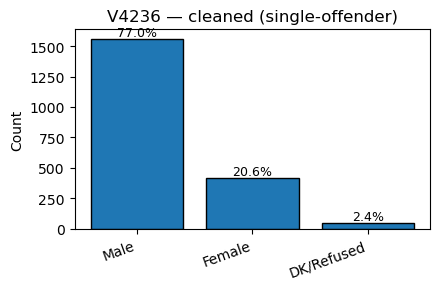

,label,size,pct
0,Male,1560,77.037037
1,Female,417,20.592593
2,DK/Refused,48,2.370370


In [59]:
freq_v4236 = plot_clean_dist("V4236", LABELS.get("V4236"))
freq_v4236


In [61]:
# Keep your LABELS / EXCLUDE_CODES as defined earlier
LABELS = {
    "V4236": {1: "Male", 2: "Female", 3: "DK/Refused"},
    "V4234": {1: "One offender", 2: "More than one", 8: "DK/Refused"},
    "V4235": {1: "Knows offender", 2: "Does not know", 8: "DK/Refused"},
}
EXCLUDE_CODES = {8, 9, 98, 99, -8, -9}

def clean_single_offender_mapped(column: str, labels: dict | None = None) -> pd.DataFrame:
    """Single-offender only, drop NaNs, drop other/unknown codes, return codes + labels."""
    df = q_single(f"SELECT {column} AS value FROM v_single_offender;").dropna(subset=["value"])
    vnum = pd.to_numeric(df["value"], errors="coerce")
    df = df[vnum.notna()].copy()
    df["code"] = vnum.astype(int)
    df = df[~df["code"].isin(EXCLUDE_CODES)]
    df["label"] = df["code"].map(labels or {}).fillna(df["code"].astype(str))
    return df[["code", "label"]]


In [62]:
import matplotlib.pyplot as plt

def plot_clean_dist(column: str, labels: dict | None = None, figsize=(4.5, 3.0)):
    """No reindexing; aggregate by code, sort by code, and plot small chart."""
    d = clean_single_offender_mapped(column, labels)
    if d.empty:
        print(f"Skipping {column} (no valid data)")
        return

    agg = (
        d.groupby(["code", "label"], as_index=False)
         .size()
         .rename(columns={"size": "count"})
         .sort_values("code")
    )
    agg["pct"] = 100 * agg["count"] / agg["count"].sum()

    plt.figure(figsize=figsize)
    plt.bar(agg["label"].astype(str), agg["count"], edgecolor="black")
    plt.title(f"{column} — cleaned (single-offender)")
    plt.xlabel("")
    plt.ylabel("Count")
    plt.xticks(rotation=20, ha="right")
    for x, (cnt, pct) in enumerate(zip(agg["count"], agg["pct"])):
        plt.text(x, cnt, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

    return agg  # table you can inspect/export


In [65]:
def plot_clean_dist(column: str, labels: dict | None = None, figsize=(4.5, 3.0)):
    """
    Plots frequency distribution for a cleaned single-offender variable
    with human-readable title from the master codebook.
    """
    # Pull label from the master codebook
    var_label = codebook_df.loc[codebook_df["Variable"] == column, "Label"].values
    title_text = var_label[0] if len(var_label) > 0 else column

    # Clean and map data
    d = clean_single_offender_mapped(column, labels)
    if d.empty:
        print(f"Skipping {column} (no valid data)")
        return

    # Aggregate
    agg = (
        d.groupby(["code", "label"], as_index=False)
         .size()
         .rename(columns={"size": "count"})
         .sort_values("code")
    )
    agg["pct"] = 100 * agg["count"] / agg["count"].sum()

    # Plot
    plt.figure(figsize=figsize)
    plt.bar(agg["label"].astype(str), agg["count"], edgecolor="black")
    plt.title(title_text)  # << show variable label only
    plt.xlabel("")
    plt.ylabel("Count")
    plt.xticks(rotation=20, ha="right")

    for x, (cnt, pct) in enumerate(zip(agg["count"], agg["pct"])):
        plt.text(x, cnt, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

    return agg


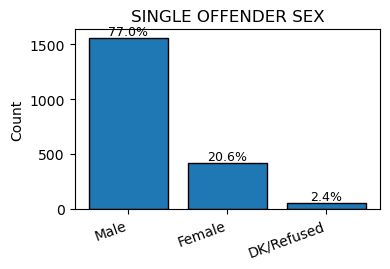

,code,label,count,pct
0,1,Male,1560,77.037037
1,2,Female,417,20.592593
2,3,DK/Refused,48,2.370370


In [66]:
# Plot for V4236 with cleaned title
freq_v4236 = plot_clean_dist("V4236", LABELS.get("V4236"), figsize=(4, 2.8))
freq_v4236


In [74]:
# --- helpers (overwrite old defs) ---
def q_single(sql, params=None):
    return pd.read_sql_query(textwrap.dedent(sql).strip(), conn, params=params)

def cols(name: str) -> list[str]:
    df = pd.read_sql_query(f"SELECT * FROM {name} LIMIT 0;", conn)
    return [c.upper() for c in df.columns]

EXCLUDE_CODES = {8, 9, 98, 99, -8, -9}

LABELS = {
    "V4236": {1: "Male", 2: "Female", 3: "DK/Refused"},
    "V4235": {1: "Knows offender", 2: "Does not know", 8: "DK/Refused"},
    "V4234": {1: "One offender", 2: "More than one", 8: "DK/Refused"},
    "V4237": {1: "Under 12", 2: "12–14", 3: "15–17", 4: "18–20", 5: "21–29", 6: "30+", 7: "Don't know", 8: "Residue"},
}

def clean_single_offender_mapped(column: str, labels: dict | None = None, exclude_labels: list | None = None) -> pd.DataFrame:
    """
    Single-offender only: drop NaNs, remove 'other/unknown' numeric codes,
    map codes->labels, and drop any labels passed in exclude_labels.
    """
    df = q_single(f"SELECT {column} AS value FROM v_single_offender;").dropna(subset=["value"])

    # numeric codes (typical NCVS)
    vnum = pd.to_numeric(df["value"], errors="coerce")
    df = df[vnum.notna()].copy()
    df["code"] = vnum.astype(int)
    df = df[~df["code"].isin(EXCLUDE_CODES)]

    # map to labels
    df["label"] = df["code"].map(labels or {}).fillna(df["code"].astype(str))

    # optional: drop specific labels (e.g., "Don't know", "Residue")
    if exclude_labels:
        df = df[~df["label"].isin(exclude_labels)]

    return df[["code", "label"]].reset_index(drop=True)


In [73]:
def plot_clean_dist(column: str, labels: dict | None = None, figsize=(5, 3.5), exclude_labels: list | None = None):
    # Pull variable label from the codebook
    var_label = codebook_df.loc[codebook_df["Variable"] == column, "Label"].values
    title_text = var_label[0] if len(var_label) > 0 else column

    # Remove "SINGLE OFFENDER" phrasing if present
    title_text = title_text.replace("SINGLE OFFENDER", "").strip()
    title_text = title_text.replace("  ", " ")

    # Clean and map data
    d = clean_single_offender_mapped(column, labels, exclude_labels=exclude_labels)
    if d.empty:
        print(f"Skipping {column} (no valid data)")
        return

    # Aggregate frequencies
    agg = (
        d.groupby(["code", "label"], as_index=False)
         .size()
         .rename(columns={"size": "count"})
         .sort_values("code")
    )
    agg["pct"] = 100 * agg["count"] / agg["count"].sum()

    # Plot
    plt.figure(figsize=figsize)
    plt.bar(agg["label"].astype(str), agg["count"], edgecolor="black")
    plt.title(title_text)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")

    # Add percentage labels
    for x, (cnt, pct) in enumerate(zip(agg["count"], agg["pct"])):
        plt.text(x, cnt, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

    return agg


In [75]:
import matplotlib.pyplot as plt

def plot_clean_dist(column: str, labels: dict | None = None, figsize=(4.0, 2.8), exclude_labels: list | None = None):
    # human-readable title from codebook; strip "SINGLE OFFENDER"
    var_label = codebook_df.loc[codebook_df["Variable"] == column, "Label"].values
    title_text = (var_label[0] if len(var_label) > 0 else column).replace("SINGLE OFFENDER", "").strip()

    d = clean_single_offender_mapped(column, labels, exclude_labels=exclude_labels)
    if d.empty:
        print(f"Skipping {column} (no valid data)")
        return

    agg = (d.groupby(["code", "label"], as_index=False)
             .size().rename(columns={"size":"count"})
             .sort_values("code"))
    agg["pct"] = 100 * agg["count"] / agg["count"].sum()

    plt.figure(figsize=figsize)
    plt.bar(agg["label"].astype(str), agg["count"], edgecolor="black")
    plt.title(title_text)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    for x, (cnt, pct) in enumerate(zip(agg["count"], agg["pct"])):
        plt.text(x, cnt, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()
    return agg


In [76]:
theme = "offender_demographics"
offender_demo_vars = [v.upper() for v in theme_vars(theme)]
view_cols = set(cols("v_single_offender"))
present_vars = [v for v in offender_demo_vars if v in view_cols]
print("Analyzing:", present_vars)


Analyzing: ['V4235', 'V4236', 'V4237', 'V4237A', 'V4238', 'V4239', 'V4240', 'V4241', 'V4242', 'V4243', 'V4244', 'V4245', 'V4246A', 'V4246B', 'V4246C', 'V4246D', 'V4246E', 'V4246F']


Skipping V4235 (no valid data)


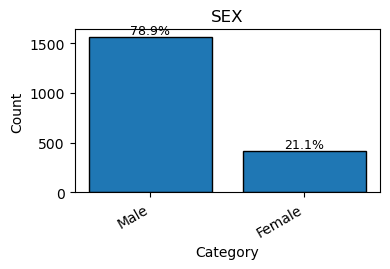

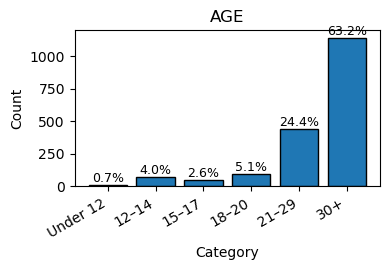

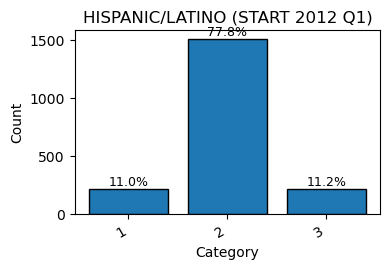

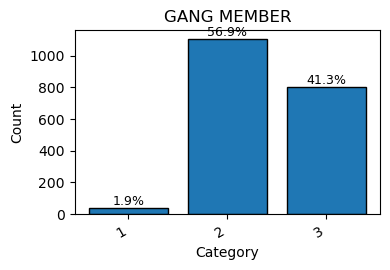

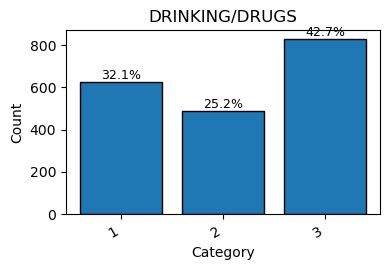

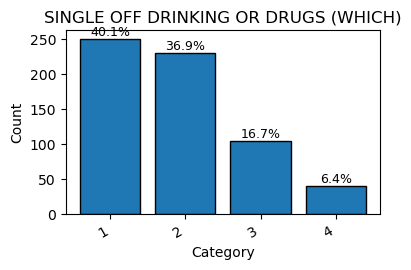

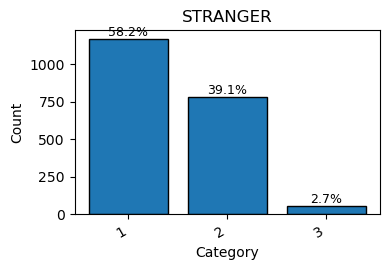

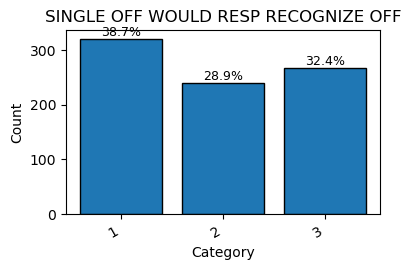

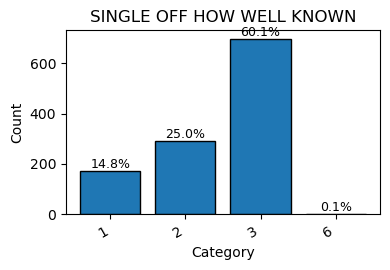

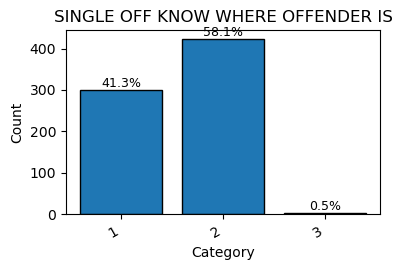

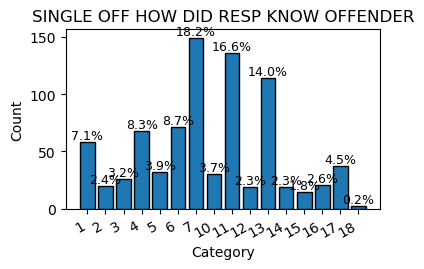

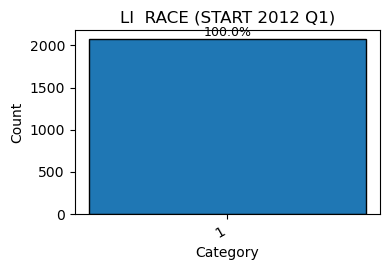

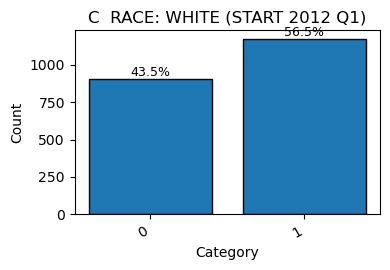

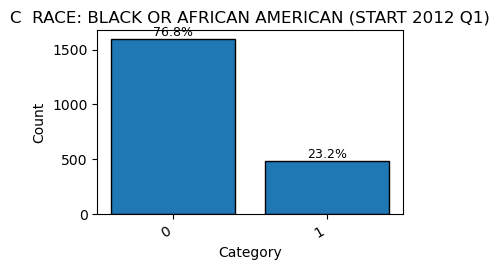

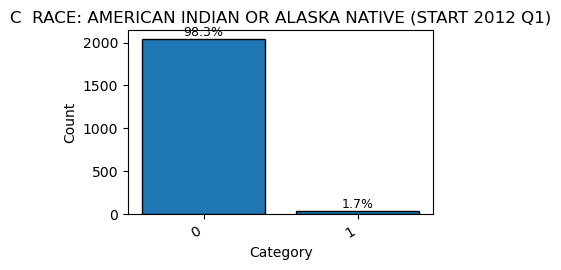

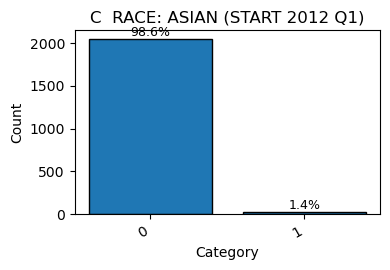

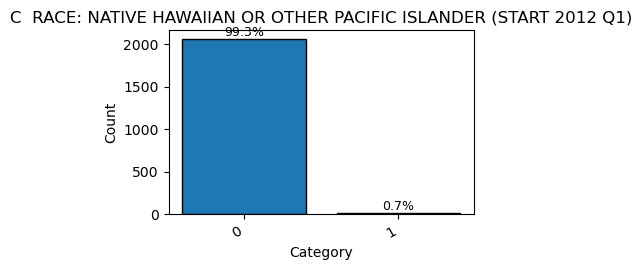

In [77]:
# exclusions per variable
variables_to_exclude = {
    "V4237": ["Don't know", "Residue"],  # age
    "V4236": ["DK/Refused"],             # sex
    "V4235": ["DK/Refused"],             # knows offender
}

for col in present_vars:
    exclude = variables_to_exclude.get(col)
    _ = plot_clean_dist(col, LABELS.get(col), figsize=(4.0, 2.8), exclude_labels=exclude)


Skipping V4235 (no valid data)


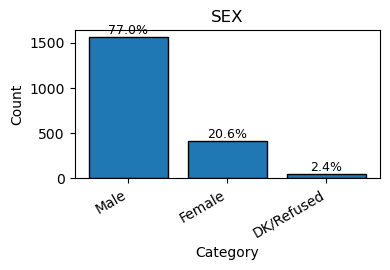

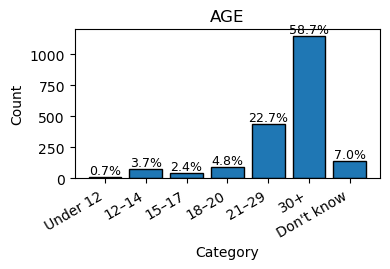

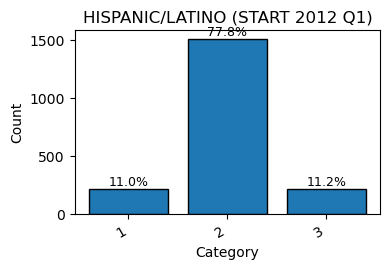

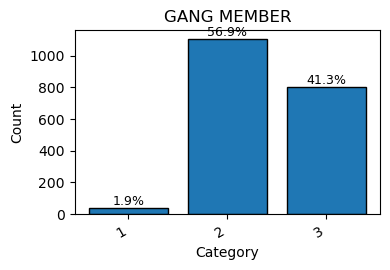

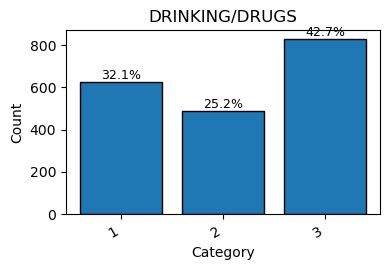

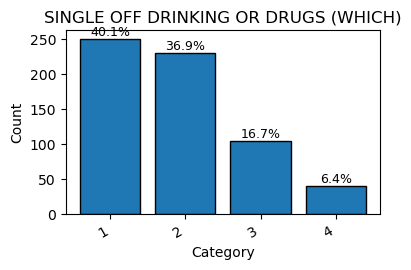

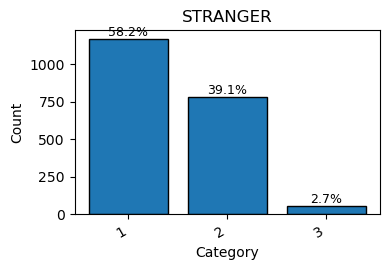

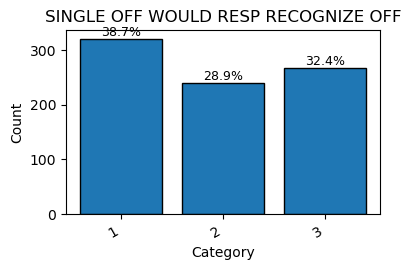

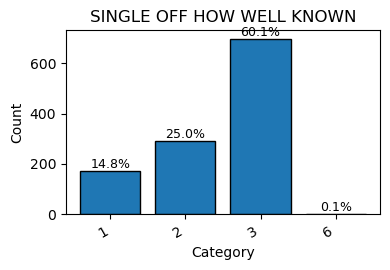

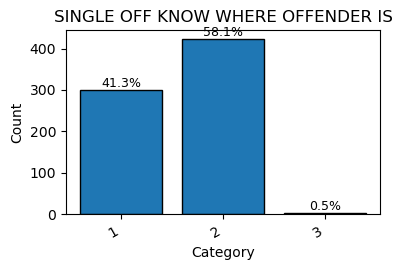

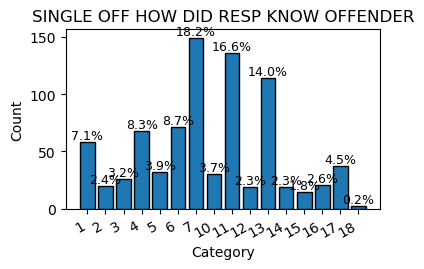

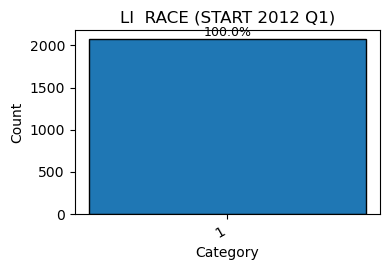

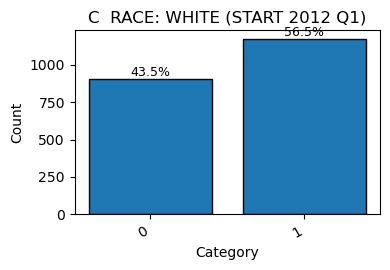

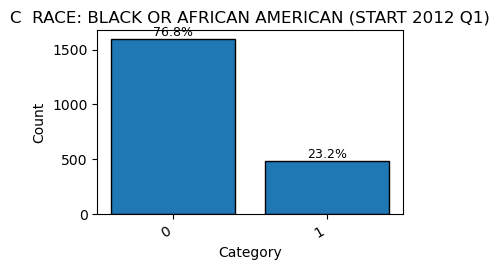

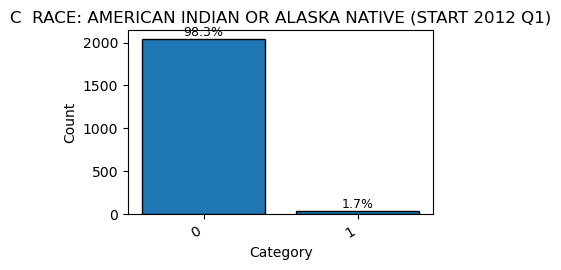

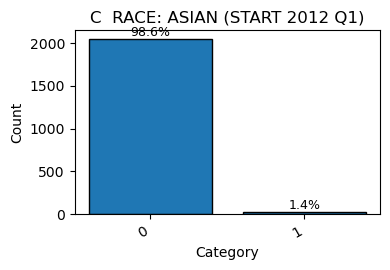

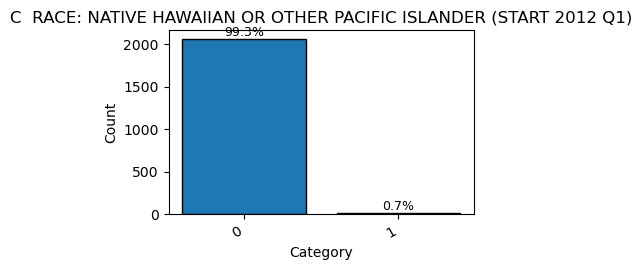

In [78]:
theme = "offender_demographics"
offender_demo_vars = [v.upper() for v in theme_vars(theme)]
view_cols = set(cols("v_single_offender"))
present_vars = [v for v in offender_demo_vars if v in view_cols]

for col in present_vars:
    _ = plot_clean_dist(col, LABELS.get(col), figsize=(4, 2.8))


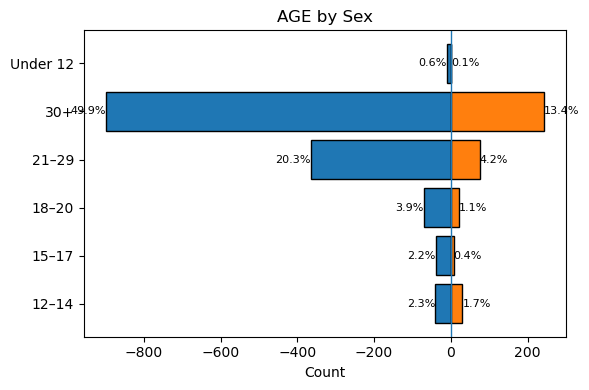

In [79]:
# --- Population pyramid: V4237 (age) × V4236 (sex) ---

# 1) Pull cleaned age and sex with labels
age = clean_single_offender_mapped("V4237", LABELS.get("V4237"), exclude_labels=["Don't know","Residue"])
sex = clean_single_offender_mapped("V4236", LABELS.get("V4236"), exclude_labels=["DK/Refused"])

# 2) Join on row order (both came from the same view in same order)
#    safer: fetch both columns together to keep alignment
agesex = q_single("SELECT V4237 AS age, V4236 AS sex FROM v_single_offender;").dropna()
agesex["age_code"] = pd.to_numeric(agesex["age"], errors="coerce").astype("Int64")
agesex["sex_code"] = pd.to_numeric(agesex["sex"], errors="coerce").astype("Int64")

# map labels
agesex = agesex.dropna()
agesex["age_label"] = agesex["age_code"].map(LABELS["V4237"])
agesex["sex_label"] = agesex["sex_code"].map(LABELS["V4236"])

# filter out unwanted labels
agesex = agesex[~agesex["age_label"].isin(["Don't know","Residue"])]
agesex = agesex[~agesex["sex_label"].isin(["DK/Refused"])]

# 3) Aggregate counts by age bin for each sex
tbl = (agesex.groupby(["age_code","age_label","sex_label"], as_index=False)
              .size()
              .rename(columns={"size":"count"})
              .sort_values("age_code"))

# 4) Pivot to pyramid structure
piv = tbl.pivot(index="age_label", columns="sex_label", values="count").fillna(0)
# ensure Male/Female columns exist
for c in ["Male","Female"]:
    if c not in piv.columns: piv[c] = 0

# 5) Plot pyramid (left = males negative, right = females positive)
import numpy as np
import matplotlib.pyplot as plt

left = -piv["Male"].values
right = piv["Female"].values
ypos = np.arange(len(piv.index))

plt.figure(figsize=(6,4))
plt.barh(ypos, left, edgecolor="black")
plt.barh(ypos, right, edgecolor="black")
plt.axvline(0, linewidth=1)

plt.yticks(ypos, piv.index)                  # age labels
plt.xlabel("Count")
# Clean title from codebook (strip 'SINGLE OFFENDER')
title_text = codebook_df.loc[codebook_df["Variable"]=="V4237","Label"].values
title_text = (title_text[0] if len(title_text) else "Offender Age").replace("SINGLE OFFENDER","").strip()
plt.title(f"{title_text} by Sex")

# Add simple % labels
total = (piv["Male"] + piv["Female"]).sum()
for y, l, r in zip(ypos, left, right):
    if l != 0:
        plt.text(l, y, f"{abs(l)/total*100:.1f}%", va="center", ha="right", fontsize=8)
    if r != 0:
        plt.text(r, y, f"{r/total*100:.1f}%", va="center", ha="left", fontsize=8)

plt.tight_layout()
plt.show()


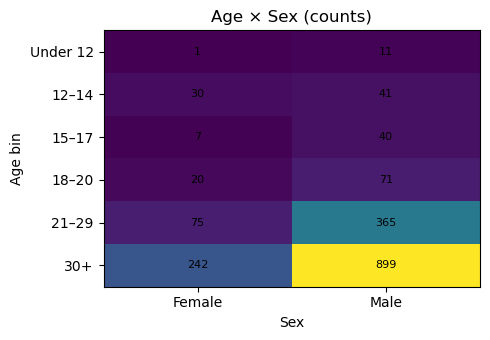

In [80]:
# --- Heatmap-like matrix (counts) for Age × Sex (single-offender) ---

# reuse the aggregated table from above if you ran it; otherwise re-create quickly
tbl = (agesex.groupby(["age_code","age_label","sex_label"], as_index=False)
              .size()
              .rename(columns={"size":"count"}))

mat = tbl.pivot(index="age_label", columns="sex_label", values="count").fillna(0)
mat = mat.reindex(index=sorted(mat.index, key=lambda s: ["Under 12","12–14","15–17","18–20","21–29","30+",
                                                         "Don't know","Residue"].index(s)
                               if s in LABELS["V4237"].values() else 0))

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3.5))
plt.imshow(mat.values, aspect="auto")
plt.xticks(range(len(mat.columns)), mat.columns, rotation=0)
plt.yticks(range(len(mat.index)), mat.index)
plt.title("Age × Sex (counts)")
plt.xlabel("Sex")
plt.ylabel("Age bin")

# annotate counts
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        plt.text(j, i, int(mat.iat[i,j]), ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()


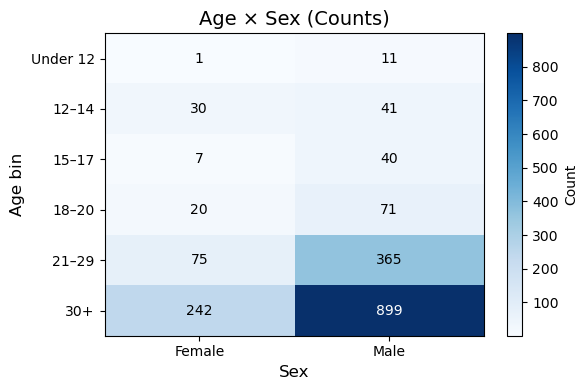

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse `mat` from your pivoted Age x Sex table
plt.figure(figsize=(6, 4))

# Use a cleaner, light-to-dark colormap for better readability
plt.imshow(mat.values, aspect="auto", cmap="Blues")

# Add gridlines for clarity
plt.grid(False)

# Axis labels and ticks
plt.xticks(range(len(mat.columns)), mat.columns, fontsize=10)
plt.yticks(range(len(mat.index)), mat.index, fontsize=10)
plt.xlabel("Sex", fontsize=12)
plt.ylabel("Age bin", fontsize=12)
plt.title("Age × Sex (Counts)", fontsize=14)

# Annotate counts in contrasting text
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        value = int(mat.iat[i, j])
        color = "white" if value > mat.values.max() * 0.6 else "black"
        plt.text(j, i, str(value), ha="center", va="center", fontsize=10, color=color)

plt.colorbar(label="Count")
plt.tight_layout()
plt.show()


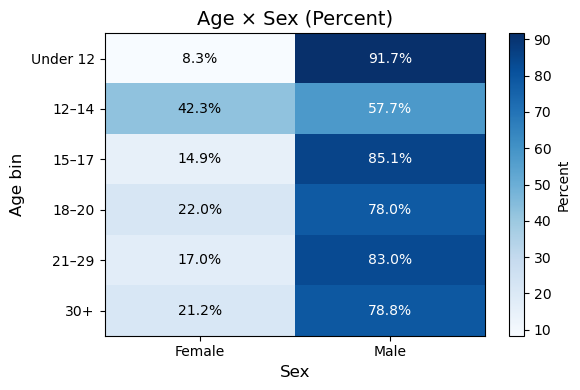

In [82]:
mat_pct = mat.div(mat.sum(axis=1), axis=0) * 100

plt.figure(figsize=(6, 4))
plt.imshow(mat_pct.values, aspect="auto", cmap="Blues")
plt.xticks(range(len(mat_pct.columns)), mat_pct.columns, fontsize=10)
plt.yticks(range(len(mat_pct.index)), mat_pct.index, fontsize=10)
plt.xlabel("Sex", fontsize=12)
plt.ylabel("Age bin", fontsize=12)
plt.title("Age × Sex (Percent)", fontsize=14)

for i in range(mat_pct.shape[0]):
    for j in range(mat_pct.shape[1]):
        value = mat_pct.iat[i, j]
        color = "white" if value > mat_pct.values.max() * 0.6 else "black"
        plt.text(j, i, f"{value:.1f}%", ha="center", va="center", fontsize=10, color=color)

plt.colorbar(label="Percent")
plt.tight_layout()
plt.show()
